# Capstone Project — The Battle of Neighborhoods in Dubai: Restaurants

Dara Sakhnini

8th July, 2020

## 1. Introduction

Dubai is a growing city with many opportunities for investors and working professionals. The city, once a desert, grows and develops into one of the richest cities in the world. Therefore, it becomes increasingly important to examine and understand it quantitatively.



Entrepreneurs, investors, and city planners have an interest in identifying opportunities and growing urban footprints in specific neighborhoods. They are interested in building in an area that meets the following criteria:

1. A neighborhood with an average to above average population density

<!-- 2. A neighborhood with an average to above average median net household incomes
 -->
After the top venues for each neighborhood are presented,this information could be of interest to potential investors looking to open a new restaurant or entertainment venue in Dubai.



## 2. Data Requirements


For this project we need following data:

1. List of communities in Dubai from Wikipedia 
https://en.wikipedia.org/wiki/List_of_communities_in_Dubai

2. Latitude and Longitude of each communities from Geocoder from Geopy Library of Python.

3. Different types of venues in each communities from Foursquare API.


## Imports

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge bs4 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge googlemaps --yes # uncomment this line if you haven't completed the Foursquare API lab



!pip install lxml



from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json
from bs4 import BeautifulSoup
from pprint import pprint

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

# 3.1 Data preparation

## 3.1.1	Scrapping data from Wikipedia

I first make use of ‘List of communities in Dubai’ page from Wikipedia to scrap the table to create a data frame. 

In [3]:
url = 'https://en.wikipedia.org/w/api.php?action=parse&prop=text&format=json&redirects&page=List%20of%20communities%20in%20Dubai&section=0'
result = requests.get(url).json()
html_data= result['parse']['text']['*']
df = pd.read_html(html_data)[0]
df.head()

,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2)
0,126.0,Abu Hail,أبو هيل,1.27 km²,21414,"16,861.4/km²"
1,711.0,Al Awir First,العوير الأولى,NaN,NaN,NaN
2,721.0,Al Awir Second,العوير الثانية,NaN,NaN,NaN
3,333.0,Al Bada,البدع,0.82 km²,18816,22946/km²
4,122.0,Al Baraha,البراحة,1.104 km²,7823,"7,086/km²"


In [4]:
df.shape

(131, 6)

## 3.1.2	Getting Coordinates

Next objective is to get the coordinates of these 131 communities using geocoder class of Geopy client

In [4]:
import geopy.geocoders

geolocator = Nominatim(user_agent='user_agent')


def get_latitude(x):
    location = geolocator.geocode(x)
    if location is not None:
        return location.latitude
    else:
        return "null"
    
df["Latitude"] = df['Community (English)'].apply(get_latitude) # create new column with specific values to conditions
df.head()


,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude
0,126.0,Abu Hail,أبو هيل,1.27 km²,21414,"16,861.4/km²",25.2859
1,711.0,Al Awir First,العوير الأولى,NaN,NaN,NaN,null
2,721.0,Al Awir Second,العوير الثانية,NaN,NaN,NaN,null
3,333.0,Al Bada,البدع,0.82 km²,18816,22946/km²,24.7542
4,122.0,Al Baraha,البراحة,1.104 km²,7823,"7,086/km²",25.2814


In [6]:
import geopy.geocoders

geolocator = Nominatim(user_agent='user_agent')

def get_longitude(x):
    location = geolocator.geocode(x)
    if location is not None:
        return location.longitude
    else:
        return "null"


df["Longitude"] = df['Community (English)'].apply(get_longitude) # create new column with specific values to conditions
df.head()



,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,126.0,Abu Hail,أبو هيل,1.27 km²,21414,"16,861.4/km²",25.2859,55.3294
1,711.0,Al Awir First,العوير الأولى,NaN,NaN,NaN,null,null
2,721.0,Al Awir Second,العوير الثانية,NaN,NaN,NaN,null,null
3,333.0,Al Bada,البدع,0.82 km²,18816,22946/km²,24.7542,46.8218
4,122.0,Al Baraha,البراحة,1.104 km²,7823,"7,086/km²",25.2814,55.3194


In [137]:
import pickle
with open('df_raw.pickle', 'wb') as f:
    pickle.dump(df, f)

## 3.1.3	Data Cleaning

Next comes cleaning the data by deleting null values, converting all values into floats, removing units, and deleting unrequired columns. 

In [7]:
df.drop(df[df["Latitude"]=="null"].index, axis=0, inplace=True) # Drop null
df.drop(df[df["Longitude"]=="null"].index, axis=0, inplace=True) # Drop null
df.drop(df[df["Population(2000)"]=="NaN"].index, axis=0, inplace=True) # Drop nill
df.drop(df[df["Area(km2)"]=="NaN"].index, axis=0, inplace=True) # Drop null
df.drop(df[df["Population density(/km2)"]=="NaN"].index, axis=0, inplace=True) # Drop null
df.dropna(inplace=True)

df.head()

,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,126.0,Abu Hail,أبو هيل,1.27 km²,21414,"16,861.4/km²",25.2859,55.3294
3,333.0,Al Bada,البدع,0.82 km²,18816,22946/km²,24.7542,46.8218
4,122.0,Al Baraha,البراحة,1.104 km²,7823,"7,086/km²",25.2814,55.3194
5,373.0,Al Barsha First,البرشاء الأولى,38.1 km²,1248,33/km²,25.1083,55.2048
11,114.0,Al Buteen,البطين,0.07 km²,2364,"33,771/km²",25.2631,55.3206


In [8]:
df['Area(km2)'] = df['Area(km2)'].str.rstrip('km²')
df['Area(km2)'] = df['Area(km2)'].str.rstrip('km2')
df['Area(km2)'] = df['Area(km2)'].astype(float)

df.head()

,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,126.0,Abu Hail,أبو هيل,1.270,21414,"16,861.4/km²",25.2859,55.3294
3,333.0,Al Bada,البدع,0.820,18816,22946/km²,24.7542,46.8218
4,122.0,Al Baraha,البراحة,1.104,7823,"7,086/km²",25.2814,55.3194
5,373.0,Al Barsha First,البرشاء الأولى,38.100,1248,33/km²,25.1083,55.2048
11,114.0,Al Buteen,البطين,0.070,2364,"33,771/km²",25.2631,55.3206


In [9]:
df['Population density(/km2)'] = df['Population density(/km2)'].str.rstrip('/km²')
df['Population density(/km2)'] = df['Population density(/km2)'].str.rstrip('/km2')
df['Population density(/km2)'] = df['Population density(/km2)'].str.replace(',','')
df['Population density(/km2)'] = df['Population density(/km2)'].astype(float)

df.head()

,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,126.0,Abu Hail,أبو هيل,1.270,21414,16861.4,25.2859,55.3294
3,333.0,Al Bada,البدع,0.820,18816,22946.0,24.7542,46.8218
4,122.0,Al Baraha,البراحة,1.104,7823,7086.0,25.2814,55.3194
5,373.0,Al Barsha First,البرشاء الأولى,38.100,1248,33.0,25.1083,55.2048
11,114.0,Al Buteen,البطين,0.070,2364,33771.0,25.2631,55.3206


In [10]:
df['Population(2000)'] = df['Population(2000)'].str.replace(']','')
df['Population(2000)'] = df['Population(2000)'].str.replace('[','')
df['Population(2000)'] = df['Population(2000)'].str.replace(',','')

df['Population(2000)'] = df['Population(2000)'].astype(float)

df.head()

,Community Number,Community (English),Community (Arabic),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,126.0,Abu Hail,أبو هيل,1.270,21414.0,16861.4,25.2859,55.3294
3,333.0,Al Bada,البدع,0.820,18816.0,22946.0,24.7542,46.8218
4,122.0,Al Baraha,البراحة,1.104,7823.0,7086.0,25.2814,55.3194
5,373.0,Al Barsha First,البرشاء الأولى,38.100,1248.0,33.0,25.1083,55.2048
11,114.0,Al Buteen,البطين,0.070,2364.0,33771.0,25.2631,55.3206


In [11]:
df=df.drop(columns='Community Number')
df=df.drop(columns='Community (Arabic)')
df.head()

,Community (English),Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,Abu Hail,1.270,21414.0,16861.4,25.2859,55.3294
3,Al Bada,0.820,18816.0,22946.0,24.7542,46.8218
4,Al Baraha,1.104,7823.0,7086.0,25.2814,55.3194
5,Al Barsha First,38.100,1248.0,33.0,25.1083,55.2048
11,Al Buteen,0.070,2364.0,33771.0,25.2631,55.3206


In [12]:
df.rename(columns = {'Community (English)':'Neighborhood'}, inplace = True) 
df.head()

,Neighborhood,Area(km2),Population(2000),Population density(/km2),Latitude,Longitude
0,Abu Hail,1.270,21414.0,16861.4,25.2859,55.3294
3,Al Bada,0.820,18816.0,22946.0,24.7542,46.8218
4,Al Baraha,1.104,7823.0,7086.0,25.2814,55.3194
5,Al Barsha First,38.100,1248.0,33.0,25.1083,55.2048
11,Al Buteen,0.070,2364.0,33771.0,25.2631,55.3206


In [151]:
import pickle
with open('df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [3]:
import pickle


with open('df.pickle', 'rb') as f:
    df = pickle.load(f)

## 3.1.4	Map 

I used python folium library to visualize geographic details of Dubai and its 131 major communities. 

In [6]:
address = 'Dubai, United Arab Emirates'

geolocator = Nominatim(user_agent="idk")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai are 25.0750095, 55.18876088183319.


In [5]:
# create map of New York using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, community in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}, {}'.format(df, community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dubai)  
    
map_dubai

# 3.2	Data Analysis

## 3.2.1	Fetching Foursquare Location Data

In [15]:
CLIENT_ID = 'F05DTOKE400DOYJRWH1N5JPIDSA0K1UCDMDQ3XPABS2QKWZ1' # your Foursquare ID
CLIENT_SECRET = 'UKGTWE51U0OXMS2U1WM1KRN4T2C4DMHKDYCR4OSFXBRNJCQR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: F05DTOKE400DOYJRWH1N5JPIDSA0K1UCDMDQ3XPABS2QKWZ1
CLIENT_SECRET:UKGTWE51U0OXMS2U1WM1KRN4T2C4DMHKDYCR4OSFXBRNJCQR


In [16]:
#Function to apply it to every Postcode we have.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
dubai_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Abu Hail
Al Bada
Al Baraha
Al Barsha First
Al Buteen
Al Garhoud
Al Hamriya Port
Al Hudaiba
Al Jaddaf
Al Jafiliya
Al Karama
Al Khabisi
Al Kifaf
Al Mamzar
Al Manara
Al Mankhool
Al Mina
Al Muraqqabat
Al Murar
Al Muteena
Al Nahda First
Al Nahda Second
Al Quoz First
Al Quoz Industrial First
Al Raffa
Al Ras
Al Rashidiya
Al Rigga
Al Sabkha
Al Safa First
Al Satwa
Al Shindagha
Al Warqa'a Third
Al Wasl
Al Waheda
Ayal Nasir
Business Bay
Bu Kadra
Hor Al Anz
Hor Al Anz East
Jebel Ali 1
Jebel Ali 2
Jebel Ali Industrial
Jumeira First
Jumeira Second
Mirdif
Nadd Al Shiba Third
Nad Shamma
Naif
Port Saeed
Rigga Al Buteen
Trade Centre 1
Trade Centre 2
Umm Al Sheif
Umm Hurair First
Umm Hurair Second
Umm Ramool
Umm Suqeim First
Za'abeel First
Za'abeel Second


In [157]:
with open('dubai_venues.pickle', 'wb') as f:
    pickle.dump(dubai_venues, f)

In [3]:
import pickle


with open('dubai_venues.pickle', 'rb') as f:
    dubai_venues = pickle.load(f)

In [31]:
dubai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abu Hail,25.285942,55.329444,Hamriya Park,25.285710,55.333000,Park
1,Abu Hail,25.285942,55.329444,Pond Park - Al Qusais,25.288060,55.332606,Park
2,Abu Hail,25.285942,55.329444,Al Farooj,25.288186,55.326324,Restaurant
3,Abu Hail,25.285942,55.329444,Zahr El Laymoun,25.289486,55.330753,Middle Eastern Restaurant
4,Al Bada,24.754227,46.821832,Tamimi Markets Express (التميمي إكسبرس),24.754251,46.824108,Supermarket


## 3.2.2	Analyzing Venue Data

In [20]:
dubai_venues_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abu Hail,2,2,2,2,2,2
Al Bada,5,5,5,5,5,5
Al Baraha,3,3,3,3,3,3
Al Barsha First,7,7,7,7,7,7
Al Buteen,15,15,15,15,15,15
Al Garhoud,1,1,1,1,1,1
Al Hudaiba,18,18,18,18,18,18
Al Jaddaf,1,1,1,1,1,1
Al Jafiliya,2,2,2,2,2,2


In [160]:
print('There are {} uniques categories.'.format(len(dubai_venues['Venue Category'].unique())))

There are 163 uniques categories.


In [4]:
dubai_venues_top10 = dubai_venues['Venue Category'].value_counts().rename_axis('unique_values').reset_index(name='counts').head(10)
dubai_venues_top10

,unique_values,counts
0,Café,84
1,Hotel,81
2,Coffee Shop,59
3,Middle Eastern Restaurant,59
4,Restaurant,38
5,Indian Restaurant,37
6,Asian Restaurant,26
7,Fast Food Restaurant,22
8,Ice Cream Shop,21
9,Bakery,14


## 3.2.3	Filtering Restaurant Data

Next, I will concentrate on Restaurant category only. I have filtered the restaurant venues as shown in the sample data frame. 

In [66]:
dubai_venues_restaurant = dubai_venues[dubai_venues["Venue Category"].str.contains(pat = 'Restaurant') ] # subset with rows that satisfy the condition
dubai_venues_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Abu Hail,25.285942,55.329444,Al Farooj,25.288186,55.326324,Restaurant
3,Abu Hail,25.285942,55.329444,Zahr El Laymoun,25.289486,55.330753,Middle Eastern Restaurant
7,Al Bada,24.754227,46.821832,La Casa Pasta,24.753953,46.824110,Italian Restaurant
23,Al Bada,24.754227,46.821832,McDonald's (ماكدونالدز),24.753915,46.824254,Fast Food Restaurant
25,Al Bada,24.754227,46.821832,McDonald's ماكدونالدز,24.750435,46.822568,Fast Food Restaurant


In [67]:
dubai_venues_restaurant_top10 = dubai_venues_restaurant['Venue Category'].value_counts().rename_axis('unique_values').reset_index(name='counts').head(10)
dubai_venues_restaurant_top10

,unique_values,counts
0,Middle Eastern Restaurant,59
1,Restaurant,38
2,Indian Restaurant,37
3,Asian Restaurant,26
4,Fast Food Restaurant,22
5,Chinese Restaurant,12
6,Italian Restaurant,9
7,Seafood Restaurant,7
8,Turkish Restaurant,6
9,Japanese Restaurant,6


In [68]:
dubai_venues_top10 = dubai_venues_restaurant['Neighborhood'].value_counts().rename_axis('unique_values').reset_index(name='counts').head(10)
dubai_venues_top10

,unique_values,counts
0,Al Karama,29
1,Al Hudaiba,18
2,Al Muraqqabat,17
3,Umm Hurair First,16
4,Al Buteen,15
5,Nadd Al Shiba Third,13
6,Al Rigga,12
7,Al Raffa,12
8,Jumeira First,12
9,Umm Hurair Second,12


Text(0.5, 1.0, 'Dubai top 10 restaurants')

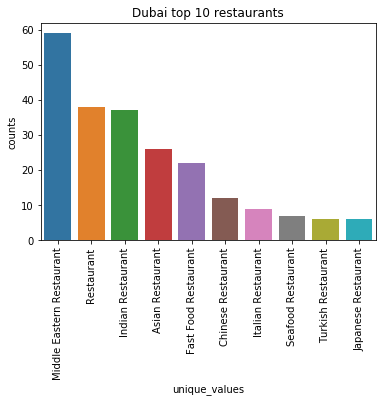

In [69]:
# Bars for each Venue Category vs. count
import seaborn as sns

# Bars for each year vs. SalesPrice
chart = sns.barplot(x = "unique_values", y = "counts", data=dubai_venues_restaurant_top10)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title("Dubai top 10 restaurants")


## 3.2.4	Top Restaurants in each community

Let’s analyze each community to discover the top 5 venues of each one

So we create a data-frame with pandas one hot encoding for the venue categories, use pandas group by on neighborhood column and calculate the mean of the frequency of occurrence of each venue category, and finally output each neighborhood along with the top 5 most common venues.

In [70]:
# one hot encoding
dubai_onehot = pd.get_dummies(dubai_venues_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dubai_onehot['Neighborhood'] = dubai_venues_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Iraqi Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Yemeni Restaurant
2,Abu Hail,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Abu Hail,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Al Bada,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,Al Bada,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,Al Bada,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
#Here we are showing the mean of what each neighborhood has close by
dubai_grouped = dubai_onehot.groupby('Neighborhood').mean().reset_index()
dubai_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Iraqi Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Yemeni Restaurant
0,Abu Hail,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Al Bada,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.400000,0.000000,0.0,0.0,0.200000,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Al Baraha,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Al Barsha First,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,Al Buteen,0.0,0.000000,0.133333,0.0,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.200000,0.0,0.0,0.0,0.066667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0


In [72]:
import pickle
with open('dubai_grouped_restuarent.pickle', 'wb') as f:
    pickle.dump(dubai_grouped, f)

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dubai_grouped['Neighborhood']

for ind in np.arange(dubai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abu Hail,Middle Eastern Restaurant,Restaurant,Yemeni Restaurant,Greek Restaurant,Kebab Restaurant
1,Al Bada,Fast Food Restaurant,Middle Eastern Restaurant,Italian Restaurant,Indian Restaurant,Yemeni Restaurant
2,Al Baraha,Middle Eastern Restaurant,American Restaurant,Yemeni Restaurant,Greek Restaurant,Kebab Restaurant
3,Al Barsha First,Indian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Restaurant
4,Al Buteen,Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Asian Restaurant,Turkish Restaurant
5,Al Garhoud,Restaurant,Yemeni Restaurant,Lebanese Restaurant,Kebab Restaurant,Japanese Restaurant
6,Al Hudaiba,Middle Eastern Restaurant,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Filipino Restaurant
7,Al Jaddaf,Indian Restaurant,Yemeni Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Kebab Restaurant
8,Al Jafiliya,Fast Food Restaurant,Restaurant,Yemeni Restaurant,Greek Restaurant,Kebab Restaurant
9,Al Karama,Indian Restaurant,Asian Restaurant,African Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant


## Joining Table

In [75]:
dubai_grouped_clustering = df.join(dubai_grouped.set_index('Neighborhood'), on='Neighborhood')
dubai_grouped_clustering = dubai_grouped_clustering.drop(columns='Neighborhood')
dubai_grouped_clustering= dubai_grouped_clustering.drop(columns='Latitude')
dubai_grouped_clustering=dubai_grouped_clustering.drop(columns='Longitude')
dubai_grouped_clustering.dropna(inplace=True)

dubai_grouped_clustering.head()


,Area(km2),Population(2000),Population density(/km2),African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Iraqi Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Yemeni Restaurant
0,1.270,21414.0,16861.4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.820,18816.0,22946.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.400000,0.000000,0.0,0.0,0.200000,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1.104,7823.0,7086.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,38.100,1248.0,33.0,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11,0.070,2364.0,33771.0,0.0,0.000000,0.133333,0.0,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.200000,0.0,0.0,0.0,0.066667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0


In [174]:
import pickle
with open('dubai_grouped_clustering.pickle', 'wb') as f:
    pickle.dump(dubai_grouped_clustering, f)

## 3.2.5	Clustering

Finally, we try to cluster these the communities based on the venue categories using K-Means clustering. So, we expect the communities to be clustered based on the similarities of venue categories.

In [76]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dubai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 2], dtype=int32)

We finally form a comprehensive data frame with cluster labels, latitude and longitude, most common venues, and population and area data. 

In [77]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dubai_merged_sorted = df
dubai_merged_sorted = dubai_merged_sorted.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
dubai_merged_sorted.head()

,Neighborhood,Area(km2),Population(2000),Population density(/km2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abu Hail,1.270,21414.0,16861.4,25.2859,55.3294,0.0,Middle Eastern Restaurant,Restaurant,Yemeni Restaurant,Greek Restaurant,Kebab Restaurant
3,Al Bada,0.820,18816.0,22946.0,24.7542,46.8218,2.0,Fast Food Restaurant,Middle Eastern Restaurant,Italian Restaurant,Indian Restaurant,Yemeni Restaurant
4,Al Baraha,1.104,7823.0,7086.0,25.2814,55.3194,0.0,Middle Eastern Restaurant,American Restaurant,Yemeni Restaurant,Greek Restaurant,Kebab Restaurant
5,Al Barsha First,38.100,1248.0,33.0,25.1083,55.2048,0.0,Indian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Restaurant
11,Al Buteen,0.070,2364.0,33771.0,25.2631,55.3206,2.0,Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Asian Restaurant,Turkish Restaurant


In [78]:
dubai_merged_sorted.dropna(inplace=True)

In [79]:
dubai_merged_sorted['Cluster Labels'] = dubai_merged_sorted['Cluster Labels'].astype(int)

We can represent these 3 clusters in a leaflet map using Folium library. 

In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dubai_merged_sorted['Latitude'], dubai_merged_sorted['Longitude'], dubai_merged_sorted['Neighborhood'], dubai_merged_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4.	Results and discussions

We got a glimpse of the Restaurants in Dubai and were able to find out some interesting insights which might be useful to travelers as well as people with business interests. Let’s summarize our findings:

1. Middle Eastern restaurants top the charts of most common venues in Dubai communities.
2. Al Karama community has maximum number of restaurants.
3. Since the clustering was based only on the category of restaurants on each district, Burj Khalifa Downtown area has a variety of restaurants different than other communities.
4. Al Mamzar, Za'abeel First, and Al Rashidiya has the least number of restaurants.


The clustering is based on the most common venues obtained from Foursquare data.

However, in this analysis, we have ignored other factors like distance of the venues from closest stations, range of prices of restaurants, and so on, since we don’t have such data and it would be difficult to obtain it for a small exploratory study like ours. Hence, our analysis only helps to get a rough overview of Restaurants distribution by categories in the 131 communities of Dubai.

Also, these results also could potentially vary if we use other clustering techniques.

# 5.	Conclusion

There are many real-life scenarios where data can be extremely useful for a wide range of people, from tourists to people with business interests. Like seen in the example above, data was used to cluster neighborhoods in Dubai based on the most common restaurants in its 131 communities. The results can help a traveler to decide about the district that fit the most his needs.

I have made use of an API library to scrap data from Wikipedia, used Foursquare API to explore the major communities of Dubai, and visualized the results of clustering the communities using Folium leaflet map. Finally, some of the drawbacks and chance for improvements to represent even more realistic pictures are mentioned.